# Demographics of Data Science Professionals <br> & Factors Affecting Data Scientist Pay
### Kim Dao

## Introduction
Over the past decade, the data science industry has grown tremendously. Numerous polls and rankings have consistently named data scientist and equivalent roles among the most well-paying and in-demand jobs. Are these claims true? Do they hold universally— or do they vary with age, gender, educational attainment, geographic location, and other factors? This project hopes to shed light on the matter of who are having access to opportunities in the data science field.

## Outline
The project will follow this structure:
1. Data
2. Visualization of Factors and their Correlations to Pay
    - Age
    - Gender
    - Race
    - Educational Attainment
    - Geographic Location 
    - Years of Experience
3. Prediction of Pay

## Data

The raw datasets used for this analysis are [Stack Overflow Annual Developer Surveys](https://insights.stackoverflow.com/survey). Stack Overflow is the most popular question and answer forum for professional and enthusiast developers. Its surveys contains a lot of demographic information on developers and their pays from 2011 to 2021. 

In this analysis, I will only focus on some factors, namely: age group, gender, ethnicity, educational attainment, geographic location, years of experience, and their correlations to the pay of data professionals. Because data scientists and analysts compose only a subset of the survey audience, I will filter the datasets to retain only records pertaining to data scientists and analysts.

Below are the data cleaning steps. The final dataset is shown at the end of this section.

In [335]:
import folium
import geopandas as gpd
import json
import matplotlib.ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [336]:
new_base_year = 2017
new_surveys = ['2017_survey_results.csv',
               '2018_survey_results.csv',
               '2019_survey_results.csv',
               '2020_survey_results.csv',
               '2021_survey_results.csv']
# TODO: remove if do not have time to clean
# old_surveys = ['2016_survey_results.csv',
#                '2015_survey_results.csv',
#                '2014_survey_results.csv',
#                '2013_survey_results.csv',
#                '2012_survey_results.csv',
#                '2011_survey_results.csv']

raw_dfs = []
for s in new_surveys:
    raw_df = pd.read_csv(s, encoding = 'ISO-8859-1', low_memory=False)
    raw_dfs.append(raw_df)

In [546]:
dfs = []
for df in raw_dfs:
    dfs.append(df.copy())

In [547]:
# Constants
AGE = 'Age'
AGE_GROUP = 'AgeGroup'
GENDER = 'Gender'
RACE = 'Race'
EDUCATION = 'EdLevel'
YOE = 'YoE'
YEARS_CODE = 'YearsCodePro'
LOCATION = 'Country'
DEV_TYPE = 'DevType'
PAY = 'ConvertedComp'
YEAR = 'Year'

# 4 groups of factor cols: 
#    1- demographics (age, gender, ethnicity)
#    2- education + year of experience
#    3- geo location
#    4- work + pay
COLS = [AGE_GROUP, GENDER, RACE,  
        EDUCATION, YEARS_CODE,
        LOCATION,
        DEV_TYPE, PAY]

In [548]:
# Rename cols for consistency

# 2017
# - NO Age
# - DeveloperType -> DevType
# - YearsCodedJob -> YearsCodePro
# - FormalEducation -> EdLevel
# - Race -> Ethnicity
# - Salary -> ConvertedComp, e notation reformat
dfs[2017 - new_base_year][AGE] = np.nan
dfs[2017 - new_base_year].rename(
    columns={
        'DeveloperType': DEV_TYPE,
        'YearsCodedJob': YEARS_CODE,
        'FormalEducation': EDUCATION,
        'Race': 'Ethnicity',
        'Salary': PAY},
    inplace=True
)

# 2018
# - YearsCodingProf -> YearsCodePro
# - ConvertedSalary -> ConvertedComp
# - RaceEthnicity -> Ethnicity
# - FormalEducation -> EdLevel
dfs[2018 - new_base_year].rename(
    columns={'YearsCodingProf': YEARS_CODE,
             'FormalEducation': EDUCATION,
             'RaceEthnicity': 'Ethnicity',
             'ConvertedSalary': PAY},
    inplace=True
)

# 2021
# - ConvertedCompYearly -> ConvertedComp
dfs[2021 - new_base_year].rename(
    columns={'ConvertedCompYearly': PAY},
    inplace=True)

# All
# - Age -> AgeGroup (only some years have raw ages, instead of age groups)
# - Ethnicity -> Race
for i in range (len(dfs)):
    dfs[i].rename(columns={AGE: AGE_GROUP}, inplace=True)
    dfs[i].rename(columns={'Ethnicity': RACE}, inplace=True)

In [549]:
# Drop unneccessary rows
for i in range(len(dfs)):
    dfs[i] = dfs[i][COLS]

In [550]:
# Filter for rows related to data science / analytics
# DevType = Data or business analyst | Data scientist or machine learning specialist | Engineer, data
for i, df in enumerate(dfs):
    df.dropna(subset=[DEV_TYPE], inplace=True)
    df = df[df[DEV_TYPE].str.contains('data|analyst', case=False, na=False, regex=True)]
    dfs[i] = df

In [551]:
# There are a lot of data points claiming to be 99 year-old people
# Exclude any data point whose age > AGE_THRESHOLD
AGE_THRESHOLD = 80
ERROR_STR = 'Error'

# 2019 & 2020 have raw ages, group them
def group_age(a):
    if a < 18:
        return 'Under 18'
    elif a >= 18 and a <= 24:
        return '18-24'
    elif a >= 25 and a <= 34:
        return '25-34'
    elif a >= 35 and a <= 44:
        return '35-44'
    elif a >= 45 and a <= 54:
        return '45-54'
    elif a >= 55 and a <= 64:
        return '55-64'
    elif a > 64 and a <= AGE_THRESHOLD:
        return 'Over 64'
    elif a > AGE_THRESHOLD:
        return ERROR_STR
    else:
        return np.nan

# Inconsistent group name formatting in other years, unify them
def get_age_group(a):
    if '18' in a:
        return 'Under 18'
    elif '18' in a or '24' in a:
        return '18-24'
    elif '25' in a or '34' in a:
        return '25-34'
    elif '35' in a or '44' in a:
        return '35-44'
    elif '45' in a or '54' in a:
        return '45-54'
    elif '55' in a or '64' in a:
        return '55-64'
    elif '65' in a:
        return 'Over 64'
    else:
        return np.nan

dfs[2018 - new_base_year][AGE_GROUP] = dfs[2018 - new_base_year][AGE_GROUP].astype(str).apply(get_age_group)
dfs[2021 - new_base_year][AGE_GROUP] = dfs[2021 - new_base_year][AGE_GROUP].astype(str).apply(get_age_group)

dfs[2019 - new_base_year][AGE_GROUP] = pd.to_numeric(dfs[2019 - new_base_year][AGE_GROUP]).apply(group_age)
dfs[2020 - new_base_year][AGE_GROUP] = pd.to_numeric(dfs[2020 - new_base_year][AGE_GROUP]).apply(group_age)

# Coincidentally, by removing from the dataset people claiming to 80+ years old, we have no one earning 2000000+ left
# If you want to see the full data in the upcoming visualisations
# Uncomment the lines below + "a > AGE_THRESHOLD" case in the group_age function 
dfs[2019 - new_base_year] = dfs[2019 - new_base_year][dfs[2019 - new_base_year][AGE_GROUP] != ERROR_STR]
dfs[2020 - new_base_year] = dfs[2020 - new_base_year][dfs[2020 - new_base_year][AGE_GROUP] != ERROR_STR]

In [552]:
dfs[2019 - new_base_year].groupby(AGE_GROUP).count() # TODO: remove

,Gender,Race,EdLevel,YearsCodePro,Country,DevType,ConvertedComp
AgeGroup,,,,,,,
18-24,3756,3312,3687,2834,3792,3792,2189
25-34,8269,7621,8268,8038,8381,8381,6580
35-44,3658,3420,3656,3582,3697,3697,2854
45-54,1222,1130,1223,1224,1246,1246,883
55-64,400,365,402,397,412,412,260
Over 64,50,45,48,49,50,50,23
Under 18,174,153,170,53,182,182,24


In [553]:
# Unify gender grouping
def get_gender(g):
    if 'Non-binary' in g or 'Gender non-conforming' in g:
        return 'Non-binary'
    elif 'Man' in g or 'Male' in g:
        return 'Man'
    elif 'Woman' in g or 'Female' in g:
        return 'Woman'
    else:
        return np.nan

for i in range(len(dfs)):
    dfs[i][GENDER] = dfs[i][GENDER].astype(str).apply(get_gender)

In [554]:
# Unify race grouping
def get_race(r):
    if r == 'Hispanic or Latino/Latina':
        return 'Hispanic or Latino/a/x'
    elif r == 'Hispanic or Latino/Latina;White or of European descent' or r == 'White or of European descent;Hispanic or Latino/a/x' or r == 'Hispanic or Latino/a/x;White or of European descent' or r == 'Hispanic or Latino/Latina; White or of European descent':
        return 'Hispanic or Latino/a/x; White or of European descent'
    elif r == 'Middle Eastern;White or of European descent' or r == 'White or of European descent;Middle Eastern':
        return 'Middle Eastern; White or of European descent'
    elif 'multiracial' in r.lower() or 'biracial' in r.lower():
        return 'Multiracial'
    elif r == 'nan' or 'prefer not to say' in r.lower() or 'know' in r.lower() or 'own words' in r.lower():
        return np.nan
    else:
        return r

for i in range(len(dfs)):
    dfs[i][RACE] = dfs[i][RACE].astype(str).apply(get_race)

In [555]:
# Unify education attaintment grouping
def get_education(e):
    if 'Primary' in e.lower() or 'elementary' in e.lower():
        return 'Primary school'
    if 'secondary' in e.lower():
        return 'Secondary school'
    elif 'associate' in e.lower():
        return 'Associate degree'
    elif 'bachelor' in e.lower():
        return 'Bachelor degree'
    elif 'master' in e.lower():
        return 'Master degree'
    elif 'doctoral' in e.lower():
        return 'Doctoral degree'
    elif 'without earning' in e.lower():
        return 'Some college/university'
    elif 'professional' in e.lower():
        return 'Professional degree'
    else:
        return 'Others'

for i in range(len(dfs)):
    dfs[i][EDUCATION] = dfs[i][EDUCATION].astype(str).apply(get_education)

In [556]:
# Unify location naming
location_replacements = {
    'United States': 'United States of America',
    'Russian Federation': 'Russia',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Iran, Islamic Republic of...': 'Iran',
    'Congo, Republic of the...': 'Democratic Republic of the Congo',
    'Democratic People\'s Republic of Korea': 'North Korea',
    'Lao People\'s Democratic Republic': 'Laos',
    'Libyan Arab Jamahiriya': 'Libya',
    'CÃ´te d\'Ivoire': 'Ivory Coast',
    'The former Yugoslav Republic of Macedonia': 'North Macedonia',
    'Republic of Korea': 'South Korea',
    'Venezuela, Bolivarian Republic of...': 'Venezuela',
    'Bosnia-Herzegovina':'Bosnia and Herzegovina'
}

for i in range(len(dfs)):
    dfs[i][LOCATION].replace(location_replacements, inplace = True)

In [557]:
# Reformat Years of Experience, rounding up to nearest integer year 
# Accepting some data loss here because 20 or more years is round to 21 years
replacements = {'Less than a year': 1,
                '1 to 2 years': 2,
                '2 to 3 years': 3,
                '3 to 4 years': 4,
                '4 to 5 years': 5,
                '5 to 6 years': 6,
                '6 to 7 years': 7,
                '7 to 8 years': 8,
                '8 to 9 years': 9,
                '9 to 10 years': 10,
                '10 to 11 years': 11,
                '11 to 12 years': 12,
                '12 to 13 years': 13,
                '13 to 14 years': 14,
                '14 to 15 years': 15,
                '15 to 16 years': 16,
                '16 to 17 years': 17,
                '17 to 18 years': 18,
                '18 to 19 years': 19,
                '19 to 20 years': 20,
                '20 or more years': 21}

for i in range(len(dfs)):
    dfs[i][YOE] = dfs[i][YEARS_CODE].replace(replacements)
    dfs[i][YOE] = pd.to_numeric(dfs[i][YOE], errors='coerce')
    dfs[i] = dfs[i].drop(columns=[YEARS_CODE])

In [558]:
# Adding in years
for i in range(len(dfs)):
    dfs[i][YEAR] = new_base_year + i

In [559]:
# dfs_copy = [] # for testing, TODO: remove
# for df in dfs:
#     dfs_copy.append(df.copy())

# dfs_copy[0].head()

Here are the list of available cleaned data columns:

In [560]:
data = pd.concat(dfs)
data.dtypes

AgeGroup          object
Gender            object
Race              object
EdLevel           object
Country           object
DevType           object
ConvertedComp    float64
YoE              float64
Year               int64
dtype: object

Here is a snippet of the fully cleaned data frame:

In [561]:
data.head()

,AgeGroup,Gender,Race,EdLevel,Country,DevType,ConvertedComp,YoE,Year
19,NaN,Man,NaN,Doctoral degree,Greece,Data scientist; Other,NaN,13.0,2017
38,NaN,Man,White or of European descent,Bachelor degree,Netherlands,Web developer; Database administrator,NaN,21.0,2017
41,NaN,NaN,NaN,Master degree,Denmark,Web developer; Database administrator; DevOps ...,NaN,18.0,2017
63,NaN,NaN,NaN,Master degree,United Kingdom,Web developer; Mobile developer; Data scientis...,NaN,3.0,2017
71,NaN,Man,White or of European descent,Bachelor degree,Finland,Web developer; Database administrator; Systems...,NaN,6.0,2017


## Visualization

This section visualises the composition of data professionals with regards to various factors, and how those factors correlate with annual pay. The visualised factors include:
- Age
- Gender
- Race
- Educational Attainment
- Geographic Location
- Years of (Programming) Experience

In [562]:
# Constants
PAIR_FIG_SIZE = (15, 6)
CNT_LABEL = 'Count'
PCT_LABEL = 'Percentage'
PAY_LABEL = 'Annual Pay'

# Common helpers
def format_pay_axis(ax, isX):
    if isX:
        axis = ax.get_xaxis()
        ax.ticklabel_format(axis='x', style='plain')
    else: 
        axis = ax.get_yaxis()
        ax.ticklabel_format(axis='y', style='plain')
        
    axis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.set_style('whitegrid')

### Age
Figure 1.1 shows that young people make up a large percentage of data scientists. Figure 1.2 indicates that there is a very weak correlation between age and pay. Even the youngest data scientists could earn the top pay brackets.

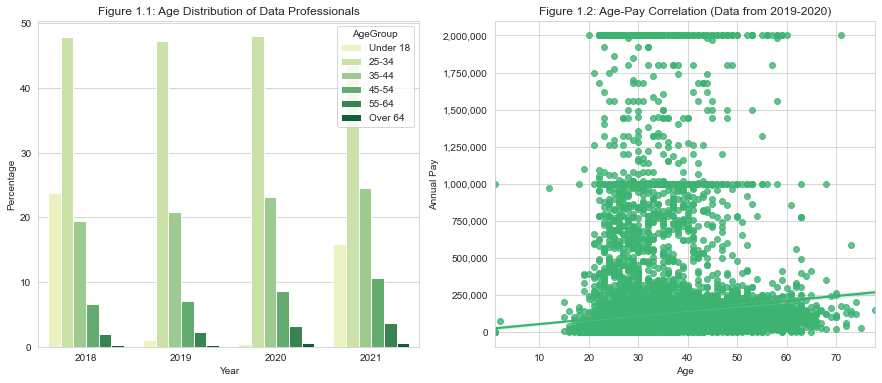

In [563]:
# Age
age_fig, age_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)

# Plot age distribution
age_dist = data.groupby([YEAR, AGE_GROUP]).size().rename(CNT_LABEL).reset_index()
age_dist[PCT_LABEL] = age_dist[CNT_LABEL] / age_dist.groupby(YEAR)[CNT_LABEL].transform('sum') * 100

age_plot = sns.barplot(
    ax=age_axes[0],
    x=YEAR, 
    y=PCT_LABEL, 
    data=age_dist, 
    palette='YlGn', # TODO: remove YlGnBu Greens_d mako YlGn summer_r
    hue=AGE_GROUP,
    hue_order=['Under 18', '25-34', '35-44', '45-54', '55-64', 'Over 64']
)

age_plot.set(title='Figure 1.1: Age Distribution of Data Professionals')

# Plot age-pay linear regression 
age_pay_data = pd.concat([raw_dfs[2019 - new_base_year], raw_dfs[2020 - new_base_year]]).loc[:, [AGE, PAY, DEV_TYPE]].dropna()
age_pay_data.rename(columns={PAY: PAY_LABEL}, inplace=True)
age_pay_data = age_pay_data[age_pay_data[DEV_TYPE].str.contains('data|analyst', case=False, na=False, regex=True)]
age_pay_data = age_pay_data[age_pay_data[AGE] < AGE_THRESHOLD] 

age_pay_plot = sns.regplot(ax=age_axes[1], x=AGE, y=PAY_LABEL, data=age_pay_data, color='mediumseagreen')
age_pay_plot.set(title='Figure 1.2: Age-Pay Correlation (Data from 2019-2020)')
format_pay_axis(age_axes[1], False)

### Gender

Figure 2.1 shows that over the years 2017-2021, men consistently make up approximately 93% of the data points, women 5%, and non-binary people 1%. This suggests that the data science field is dominated by men. However, average pay is relatively equal across all gender groups, as suggested by Figure 2.2. Still, outliers at the higher pays are mostly men.

Here are the visualizations:

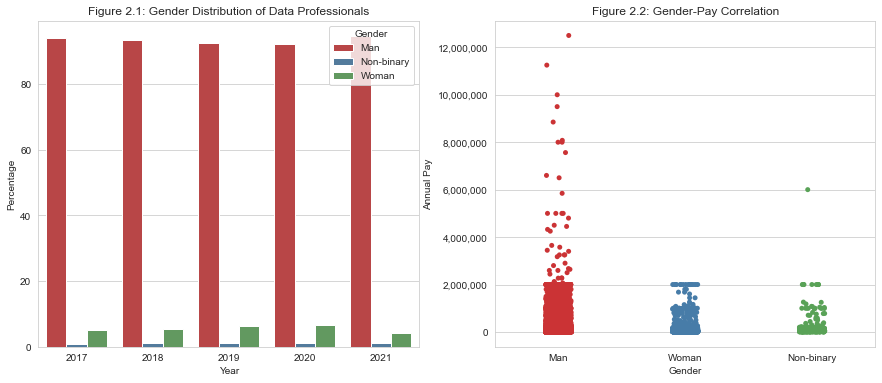

In [572]:
# Gender 
gender_fig, gender_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)
pal = sns.color_palette('Set1', 3, .75)

gender_dist = data.groupby([YEAR, GENDER]).size().rename(CNT_LABEL).reset_index()
gender_dist[PCT_LABEL] = gender_dist[CNT_LABEL] / gender_dist.groupby(YEAR)[CNT_LABEL].transform('sum') * 100

gender_plot = sns.barplot(
    ax=gender_axes[0],
    x=YEAR, 
    y=PCT_LABEL, 
    data=gender_dist,
    palette=pal,
    hue=GENDER
)
gender_plot.set(title='Figure 2.1: Gender Distribution of Data Professionals')

# Plot correlation
sns.set_palette(pal)
gender_pay_data = data.loc[:, [GENDER, PAY]].dropna()

gender_pay_data.rename(columns={PAY: PAY_LABEL}, inplace=True)

gender_pay_plot = sns.stripplot(ax=gender_axes[1], 
                                x=GENDER, 
                                y=PAY_LABEL, 
                                data=gender_pay_data, 
                                palette=pal)
gender_pay_plot.set(xlabel=GENDER, title='Figure 2.2: Gender-Pay Correlation')
format_pay_axis(gender_axes[1], False)

Here are the percentages:

In [565]:
gender_dist[[YEAR, GENDER, PCT_LABEL]].set_index([YEAR, GENDER])

Percentage
Year Gender                
2017 Man          93.990755
     Non-binary    0.866718
     Woman         5.142527
2018 Man          93.358793
     Non-binary    1.087449
     Woman         5.553758
2019 Man          92.502353
     Non-binary    1.244379
     Woman         6.253268
2020 Man          92.153370
     Non-binary    1.228087
     Woman         6.618543
2021 Man          94.557554
     Non-binary    1.251683
     Woman         4.190763

### Race

Similar to age and gender, there is a dominant group amongst data professional in terms of race. Figure 3.1 shows that over the years 2017-2021, data professionals of White or European descent consistently make up an overwhelming majority. However, also like gender, average pay is relatively equal across all race groups, as suggested by Figure 3.2. All race groups have access to annual pay of up to 2,000,000 USD. Beyond that pay, there are a lot more people of White or European descent than of any other race, but this could be attributed to greater number of Whites and Europeans in the field.

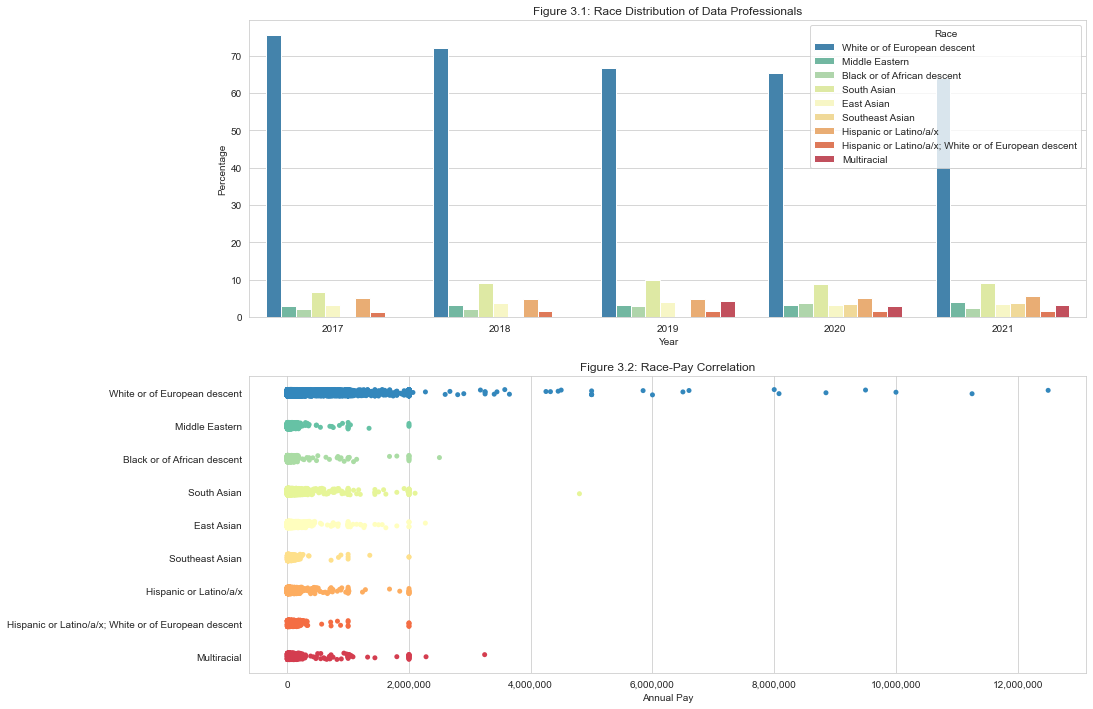

In [573]:
# Race 
race_fig, race_axes = plt.subplots(2, 1, figsize=(PAIR_FIG_SIZE[0], 2*PAIR_FIG_SIZE[1]))

# Plot race distribution
race_pct_threshold = 1
order = [
    'White or of European descent', 
    'Middle Eastern', 
    'Black or of African descent', 
    'South Asian', 
    'East Asian', 
    'Southeast Asian', 
    'Hispanic or Latino/a/x',
    'Hispanic or Latino/a/x; White or of European descent',
    'Multiracial'
]

race_dist = data.groupby([YEAR, RACE]).size().rename(CNT_LABEL).reset_index()
race_dist[PCT_LABEL] = race_dist[CNT_LABEL] / race_dist.groupby(YEAR)[CNT_LABEL].transform('sum') * 100
dominant_race_dist = race_dist[race_dist[PCT_LABEL] > race_pct_threshold]

race_plot = sns.barplot(
    ax=race_axes[0],
    y=PCT_LABEL, 
    x=YEAR, 
    data=dominant_race_dist,
    palette='Spectral_r',
    hue=RACE,
    hue_order=order
) # TODO: remove Set3 Spectral 

race_plot.set(title='Figure 3.1: Race Distribution of Data Professionals')

# Plot correlation
race_pay_data = data.loc[:, [RACE, PAY]].dropna().rename(columns={PAY: PAY_LABEL})

dominant_race_pay_data = race_pay_data.loc[race_pay_data[RACE].isin(list(dominant_race_dist[RACE]))]
race_pay_plot = sns.stripplot(
    ax=race_axes[1], 
    y=RACE, 
    x=PAY_LABEL, 
    data=dominant_race_pay_data, 
    palette='Spectral_r',
    order=order
)
race_pay_plot.set(xlabel=PAY_LABEL, ylabel='', title='Figure 3.2: Race-Pay Correlation')
format_pay_axis(race_axes[1], True)

### Educational Attainment 

Figure 4.1 shows that a bell-curved distribution of educational attaintment amongst data professionals. Most completed bachelors and masters, whilst a smaller number possessed lesser and greater degrees of educational attaintment.
However, average pay is relatively equal across all educational groups, as suggested by Figure 4.2. This parallels the observed correlations between pay and age / gender / race: the correlations between pay and each of these factors are all rather weak. People with higher educational attaintment do not seem to definitively earn more. Likewise, people with lesser educational attaintment do not seem to earn less.

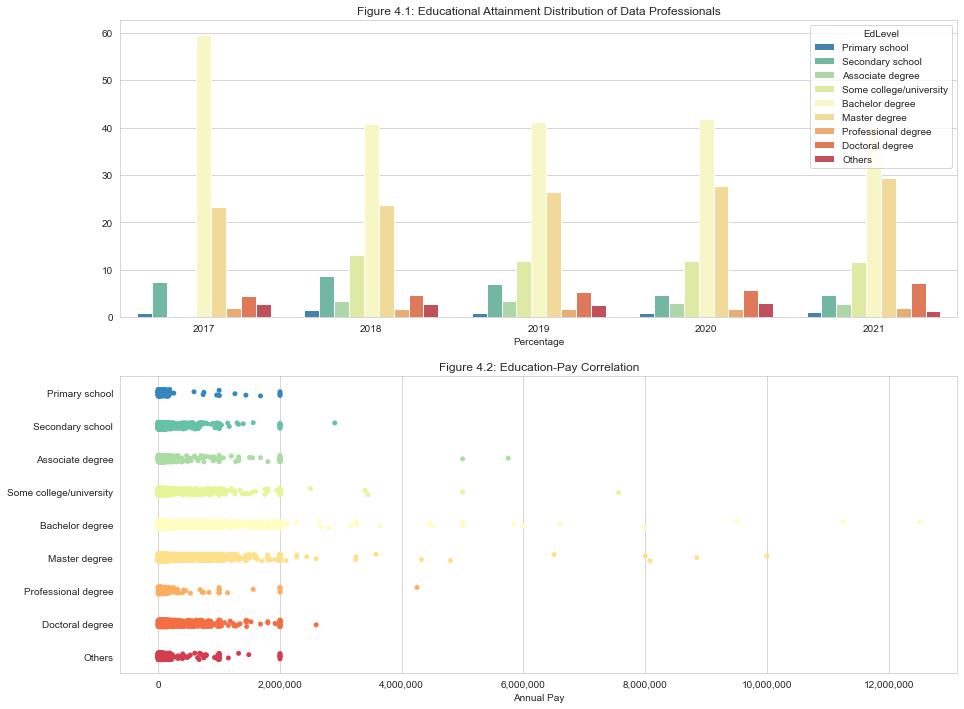

In [576]:
# Educational Attainment  
edu_fig, edu_axes = plt.subplots(2, 1, figsize=(PAIR_FIG_SIZE[0], 2*PAIR_FIG_SIZE[1]))

# Plot education distribution
order = [
    'Primary school',
    'Secondary school',
    'Associate degree',
    'Some college/university',
    'Bachelor degree', 
    'Master degree',
    'Professional degree',
    'Doctoral degree',
    'Others'
]

edu_dist = data.groupby([YEAR, EDUCATION]).size().rename(CNT_LABEL).reset_index()
edu_dist[PCT_LABEL] = edu_dist[CNT_LABEL] / edu_dist.groupby(YEAR)[CNT_LABEL].transform('sum') * 100

edu_plot = sns.barplot(
    ax=edu_axes[0],
    y=PCT_LABEL, 
    x=YEAR, 
    data=edu_dist,
    palette='Spectral_r',
    hue=EDUCATION,
    hue_order=order
)

edu_plot.set(xlabel=PCT_LABEL, ylabel='', title='Figure 4.1: Educational Attainment Distribution of Data Professionals')

# Plot correlation
edu_pay_data = data.loc[:, [EDUCATION, PAY]].dropna().rename(columns={PAY: PAY_LABEL})

edu_pay_plot = sns.stripplot(
    ax=edu_axes[1], 
    y=EDUCATION, 
    x=PAY_LABEL, 
    data=edu_pay_data, 
    palette='Spectral_r',
    order=order
)
edu_pay_plot.set(xlabel=PAY_LABEL, ylabel='', title='Figure 4.2: Education-Pay Correlation')
format_pay_axis(edu_axes[1], True)

### Years of Experience 

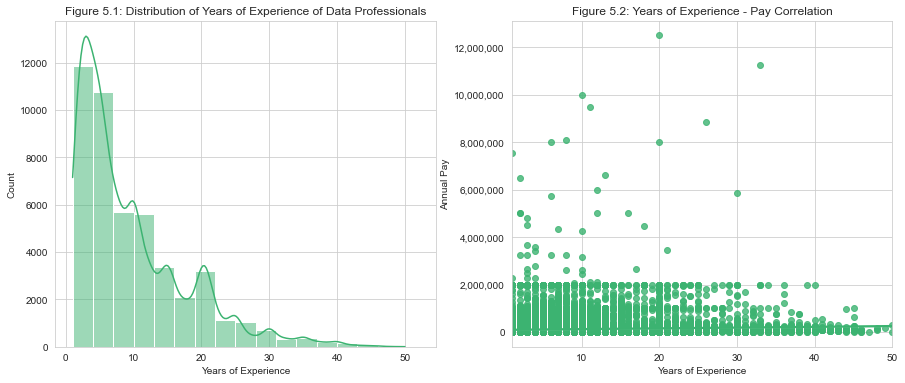

In [577]:
# Years of Experience 
yoe_fig, yoe_axes = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)

# Plot age distribution
yoe_dist = data.dropna(subset=[YOE])

yoe_plot = sns.histplot(
    ax=yoe_axes[0],
    x=YOE, 
    data=yoe_dist, 
    color='mediumseagreen',
    binwidth=3,
    kde=True
)
yoe_plot.set(xlabel='Years of Experience', title='Figure 5.1: Distribution of Years of Experience of Data Professionals')

# Plot yoe-pay linear regression 
yoe_pay_data = data.loc[:, [YOE, PAY]].dropna().rename(columns={PAY: PAY_LABEL})

yoe_pay_plot = sns.regplot(
    ax=yoe_axes[1], 
    x=YOE, 
    y=PAY_LABEL, 
    data=yoe_pay_data, 
    color='mediumseagreen'
)
yoe_pay_plot.set(xlabel='Years of Experience', title='Figure 5.2: Years of Experience - Pay Correlation')
format_pay_axis(yoe_axes[1], False)

### Geographic Location 

The choropleth map below illustrates that the U.S employs the highest number of data professionals, closely followed by India and Germany. Ten countries that employ the highest number of data professionals are circled in red below, along with their ranks.

In [580]:
# Geographic Location 

# Add basic map
base_geo_data_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
world_geo_data = f'{base_geo_data_url}/world-countries.json'
counts = pd.DataFrame(data={'Counts': data[LOCATION].value_counts(dropna=True)})
counts = counts.reset_index()
counts = counts.rename(columns={'index': 'Country'})
count_bins = [0, 1000, 5000, 10000, 15000, 20000]

count_map = folium.Map()
folium.Choropleth(
    geo_data=world_geo_data,
    data=counts,
    columns=['Country', 'Counts'],
    bins=count_bins,
    key_on='feature.properties.name',
    fill_color ='YlGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Number of Data Professionals',
    nan_fill_color='white'
).add_to(count_map)

# Add markers for interesting (Top 10) data points
LAT = 'latitude'
LONG = 'longitude'
nlargest = 10

high_counts = counts.nlargest(nlargest, 'Counts').set_index('Country')

raw_json = json.loads(open('country-lat-long.json').read())['ref_country_codes']
world_coords = {}
for c in raw_json:
    world_coords[c['country']] = { LAT: c[LAT], LONG: c[LONG] }

world_coords['United States of America'] = world_coords['United States']
world_coords['Russia'] = world_coords['Russian Federation']
del world_coords['United States']
del world_coords['Russian Federation']

for i, c in enumerate(list(high_counts.index)):
    annotation = f"#{i+1}: {c}"
    folium.Circle(
        location=[world_coords[c][LAT], world_coords[c][LONG]],
        tooltip=annotation,
        color='red',
        radius=100 * int(high_counts.loc[c]['Counts']),
        weight=1,
        fill=True,
        fill_opacity=0.3,
    ).add_to(count_map)

count_map

### Pay

There is a very wide range in terms of pay in data science, as shown by Figure 6.1 below. However, the interquartile range is much smaller, as shown by Figure 6.2 below.

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, 'Annual Pay'),
 Text(0.5, 1.0, 'Figure 6.3: Pay Distribution in the Interquatile Range')]

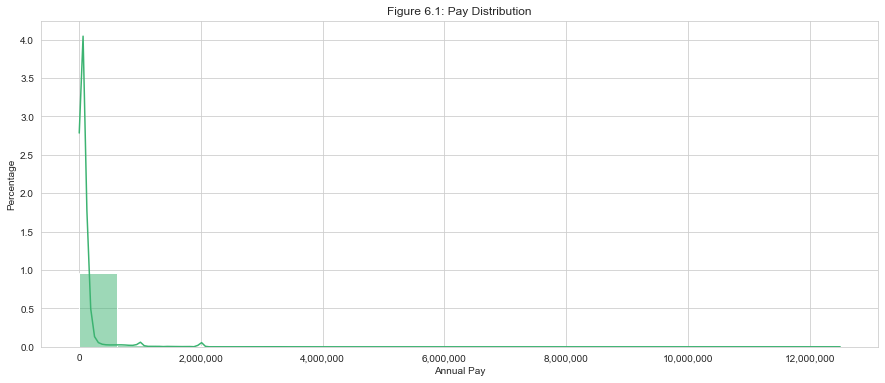

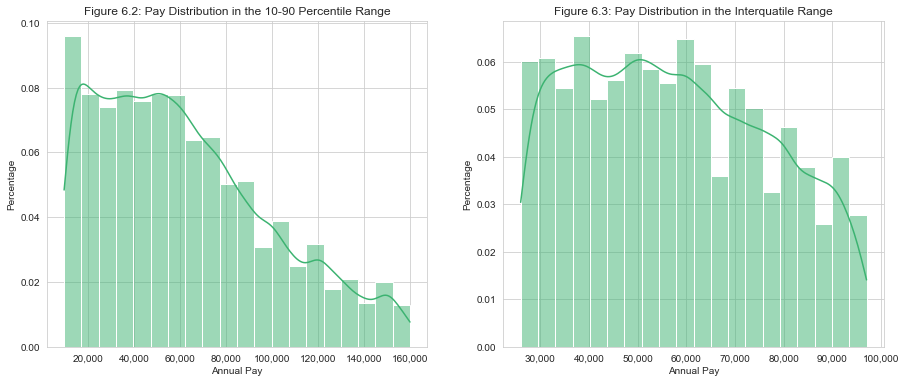

In [598]:
# Pay
pay_fig_1, pay_axes_1 = plt.subplots(figsize=PAIR_FIG_SIZE)

# All
pay_plot = sns.histplot(
    ax=pay_axes_1,
    x=PAY, 
    data=data, 
    color='mediumseagreen',
    bins=20,
    kde=True,
    stat='probability'
)

format_pay_axis(pay_axes_1, True)
pay_plot.set(ylabel=PCT_LABEL, xlabel=PAY_LABEL, title='Figure 6.1: Pay Distribution')

pay_fig_2, pay_axes_2 = plt.subplots(1, 2, figsize=PAIR_FIG_SIZE)

# 10-90
percentiles = data[PAY].quantile([0.10, 0.90])
most_pay_data = data.loc[(data[PAY] >= percentiles[0.10]) & (data[PAY] <= percentiles[0.90])]

most_pay_plot = sns.histplot(
    ax=pay_axes_2[0],
    x=PAY, 
    data=most_pay_data, 
    color='mediumseagreen',
    bins=20,
    kde=True,
    stat='probability'
)

format_pay_axis(pay_axes_2[0], True)
most_pay_plot.set(ylabel=PCT_LABEL, xlabel=PAY_LABEL, title='Figure 6.2: Pay Distribution in the 10-90 Percentile Range')

# 25-75
quantiles = data[PAY].quantile([0.25, 0.75])
mid_pay_data = data.loc[(data[PAY] >= quantiles[0.25]) & (data[PAY] <= quantiles[0.75])]

mid_pay_plot = sns.histplot(
    ax=pay_axes_2[1],
    x=PAY, 
    data=mid_pay_data, 
    color='mediumseagreen',
    bins=20,
    kde=True,
    stat='probability'
)

format_pay_axis(pay_axes_2[1], True)
mid_pay_plot.set(ylabel=PCT_LABEL, xlabel=PAY_LABEL, title='Figure 6.3: Pay Distribution in the Interquatile Range')

## Prediction

## Citations
1. [Folium Documentation](https://python-visualization.github.io/folium/quickstart.html)
2. [Stack Overflow: Pandas percentage of total with groupby](https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby)
3. [Stack Overflow: UnicodeDecodeError when reading CSV file in Pandas with Python](https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python)